In [1]:
%load_ext autoreload
%autoreload 2
import torch, timm, cv2
from torchvision.transforms import transforms
from softdataset import TripletImageDataset, data_split
from original_dataset import OriginalImageDataset, data_split, OriginalDataset
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader
from torchvision import transforms
import glob, os, random, json
from dataset import TripleDataset
from torch.nn import *
from collections import OrderedDict as OD
from tqdm import tqdm
import numpy as np
from PIL import Image
from sketch_dataset import SketchyImageDataset, SketchyDataset
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Inference with SketchyDatabase

In [2]:
def get_fm(fm):
        pool = AvgPool2d((fm.shape[2],fm.shape[3]))
        return torch.reshape(pool(fm), (-1, fm.shape[1]))

def get_dl(path, bs, random = True, trainval_json="", trainval="test"):        
    
    ''' 
    Get path to the images and returns dataloader with transformations applied
    Arguments:

    path - path to the dir with images;
    bs - batch_size;
    random - if False loads train test split json file else randomly mix dataset.      

    '''
    
    transformations = {}   

    transformations['qry'] = transforms.Compose([
                            transforms.Resize((224,224)),
                            # transforms.RandomHorizontalFlip(),
                            # transforms.RandomRotation(90, fill = fill),
                            # transforms.ColorJitter([0.3, 1]),
                            # transforms.GaussianBlur(9, (0.5, 3.0)),
                            transforms.ToTensor(),
                                                  ])

    transformations['pos'] = transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.RandomRotation(90, fill = fill_sketch),
        # transforms.RandomPerspective(distortion_scale = distortion_scale, p = p, fill = fill_sketch),
        transforms.ToTensor(),
    ])  
    transformations['neg'] = transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.RandomRotation(90, fill = fill_sketch),
        # transforms.RandomPerspective(distortion_scale = distortion_scale, p = p, fill = fill_sketch),
        transforms.ToTensor(),
    ])
    
    out_path = "data/sketchy_database_256_soft_split_cat.json"
    # out_path = data_split(path, out_path)

    # tr_ds = SketchyImageDataset(data_dir = path, transform_dic=transformations, random=True, trainval_json=out_path, trainval='train', load_images=False)
    # val_ds = SketchyImageDataset(data_dir = path, transform_dic=transformations, random=True, trainval_json=out_path, trainval='val', load_images=False)
    path_dataset = SketchyDataset(data_dir = path, random = random, trainval_json=trainval_json, trainval=trainval)
    dataset = SketchyImageDataset(data_dir = path, transform_dic=transformations, random=True, trainval_json=out_path, trainval=trainval, load_images=False)
    
    transformations = {}   

    transformations['qry'] = transforms.Compose([transforms.ToTensor()])
    transformations['pos'] = transforms.Compose([transforms.ToTensor()])
    transformations['neg'] = transforms.Compose([transforms.ToTensor()])
    
    # dataset = OriginalImageDataset(data_dir = path, transform_dic=transformations, random=True, load_images=False)
    num_classes = dataset.get_cat_length()
    print(f"The dataset has {num_classes} classes")    
    print(f"Number of test samples: {len(dataset)}")
    
    test_dl = DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True, num_workers=8)

    return num_classes, dataset, test_dl, path_dataset


def load_checkpoint(checkpoint_path, model_name, pretrained=False, num_classes=None, from_pytorch_lightning=True, init_conv=False):

        ''' 
        
        Loads checkpoint_path from the given path to the directory with the trained model.
        Arguments:
        
        checkpoint_path - path to the dir with the trained model;
        model_name - name of the trained model (name is the same as in the timm library);
        pretrained - creates a model with pretrained weights on ImageNet;
        init_conv - initial convolution layer, default is True;
        from_pytorch_lightning - used to load the trained model from pytorch_lightning.
        If True the model is trained using pytorch_lightning, else with a regular torch library;
        Default is False
        
        '''        
        assert num_classes is not None, "Please set the number of classes in the dataset!"
        
        if from_pytorch_lightning: # for a pytorch_lightning model
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            # print(checkpoint['state_dict'].keys())
            if init_conv:                
                base_model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
                conv_layer = torch.nn.Sequential(torch.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1),padding=(1,1), bias=False), 
                 # nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2),padding=(1,1), bias=False), 
                 # nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1)),
                 torch.nn.SiLU(inplace=True))
                model = torch.nn.Sequential(conv_layer, base_model) 
                print("Model with init_conv True")
            else:
                model = timm.create_model(model_name, num_classes=num_classes)
                # model.head.fc = Identity()
                print("Model with init_conv False")

            # create new OrderedDict that does not contain `model.` (for the checkpoint from the pytorch_lightning)
            new_state_dict = OD()
            for k, v in checkpoint['state_dict'].items():
                name = k.replace("model.", "") # remove `model.`
                new_state_dict[name] = v
            # load params
            model.load_state_dict(new_state_dict, strict=True)
            print(f"Model {model_name} trained using pytorch lightning checkpoint is successfully loaded!")

        else: # for a regular torch model  
            if pretrained:
                model = timm.create_model(model_name, num_classes=num_classes)
                print(f"Model {model_name} with pretrained weights is successfully loaded!")
            else:
                model = timm.create_model("rexnet_150", num_classes=num_classes)
                state_dict = torch.load(checkpoint_path, map_location=device)
                model.load_state_dict(state_dict)
                print(f"Model {model_name} with the best weights is successfully loaded!")            

        return model
    
def inference(model, dataloader, device):

        ''' 
        
        Inference using trained model and test dataloader.
        Arguments:
        
        model - trained model from the checkpoint (see load_checkpoint function);
        dataloader - test dataloader (see get_dl function);
        device - gpu device.
        
        '''   
        
        ims, poss, negs, pos_scores, neg_scores, fms_ims_all, top_vals, scores, fms_poss_all, fms_negs_all,  classes_all, top_inds, top_r_list, pred_lbls_all = [], [], [], [], [], [], [], [], [], [], [], [], [], []
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        model.to(device)
        model.eval()
        model.head = Identity()
        
        print("Obtaining embeddings...")        
        for i, batch_all in tqdm(enumerate(dataloader)):
            ims_all, poss_all, negs_all, clss_all, regs_all = batch_all['qry'], batch_all['pos'][0], batch_all['neg'][0], batch_all['cat_idx'], batch_all['prod_idx']
            ims.extend(ims_all)
            poss.extend(poss_all)
            negs.extend(negs_all)
            classes_all.extend(clss_all.to(device)) 
            
            with torch.no_grad():
                
                # with torch.cuda.amp.autocast():
                fm_ims_all = model.forward_features(ims_all.to(device))            
                # lbl_ims_all = model.head(fm_ims_all)
                fm_poss_all = model.forward_features(poss_all.to(device))
                # lbl_poss_all = model.head(fm_poss_all)
                fm_negs_all = model.forward_features(negs_all.to(device))
                # lbl_negs_all = model.head(fm_negs_all)
                fm_ims_all = get_fm(fm_ims_all)
                fm_poss_all = get_fm(fm_poss_all)
                fm_negs_all = get_fm(fm_negs_all)
                fms_ims_all.extend(fm_ims_all) #bs, fm 
                fms_poss_all.extend(fm_poss_all)
                fms_negs_all.extend(fm_negs_all)

        print("Embeddings are obtained!")        
        print("Calculating metrics...")
        top1 = 0 
        top3 = 0
        fms_ims_all = torch.stack(fms_ims_all) 
        fms_poss_all = torch.stack(fms_poss_all)
        fms_negs_all = torch.stack(fms_negs_all)        
        ims = torch.stack(ims)
        poss = torch.stack(poss)        
        negs = torch.stack(negs)        
        classes_all = torch.stack(classes_all)
        
        
        for idx, (gt_reg, fm) in enumerate(zip(classes_all, fms_ims_all)):
            pos_score = cos(fm.unsqueeze(0), fms_poss_all[idx].unsqueeze(0)) #(len(dl))
            pos_scores.append(pos_score.item())
            neg_score = cos(fm.unsqueeze(0), fms_negs_all[idx].unsqueeze(0)) #(len(dl))
            neg_scores.append(neg_score.item())
            vals, inds = torch.topk(cos(fm, fms_poss_all), k=150)
            
            classes = [int(classes_all[int(ind)]) for ind in inds]
            top_i, top_v, top_r, top_c = [], [], [], []
            
            for num, (i, v, r) in enumerate(zip(inds, vals, classes)):
                if r not in top_r:
                    top_r.append(r)
                    top_v.append(v)
                    top_i.append(int(i))
                if len(top_r) == 3:
                    break
            top3 += 1 if int(gt_reg) in top_r else 0
            top1 += 1 if int(gt_reg) == top_r[0] else 0
            
            top_inds.append(top_i)
            top_vals.append(top_v)
            top_r_list.append(top_r)        
            
        return OD([('top1', top1/len(fms_ims_all)), ('top3', top3/len(fms_ims_all)), ('scores', torch.mean(torch.FloatTensor(pos_scores))),
                    ('fms_ims_all', fms_ims_all), ('classes_all', classes_all), ('fms_poss_all', fms_poss_all),
                    ('ims', ims), ('poss', poss), ('negs', negs), ('fms_negs_all', fms_negs_all),
                    ('topk_inds_reg', top_r_list), ('topk_inds', top_inds), ('top_vals', top_vals), ('top_r_list', top_r_list)])

In [3]:
path = "/home/ubuntu/workspace/dataset/sketchy_database_256"
bs=32
device='cuda:1'
num_classes, test_ds, test_dl, path_ds = get_dl(path=path, bs=bs)
idx_to_clss = {v:k for k,v in test_ds.cat_idx.items()}
checkpoint_path = "/home/ubuntu/workspace/bekhzod/pytorch_lightning/saved_models/rexnet_150_Adam_0.0047863/Sketchy-Dataset-Training/3ghvkf5c/checkpoints/epoch=33-val_loss=0.28-cos_sims=0.92-val_top1=0.01.ckpt"
m = load_checkpoint(checkpoint_path, num_classes=num_classes, from_pytorch_lightning=True, model_name='rexnet_150')
results = inference(m, test_dl, device)
results['top3'], results['top1'], results['scores']

The dataset has 125 classes
Number of test samples: 8736
Model with init_conv False
Model rexnet_150 trained using pytorch lightning checkpoint is successfully loaded!
Obtaining embeddings...


273it [00:36,  7.49it/s]


Embeddings are obtained!
Calculating metrics...


(0.9760760073260073, 0.9481456043956044, tensor(0.9226))


	Input Image
	Class: pineapple


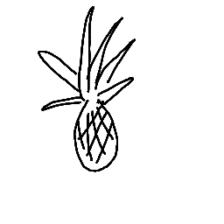


	Positive Image
	Class: pineapple


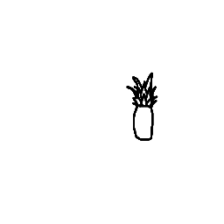


					Predicted Images
					   Grad CAM



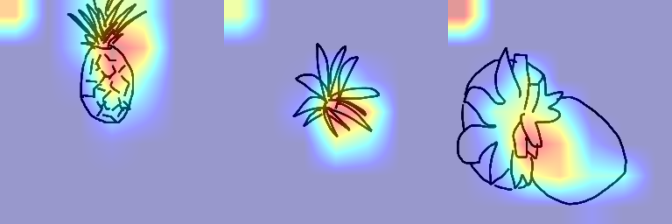

	cos_sim:0.974 			cos_sim:0.822 			cos_sim:0.790
	pred_class: pineapple 		pred_class: flower 		pred_class: strawberry


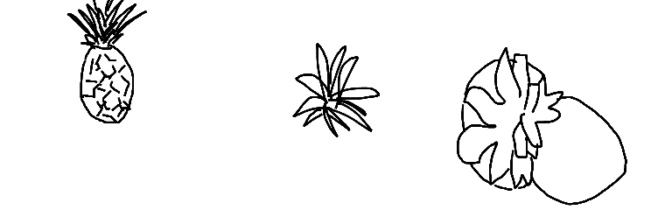


	Input Image
	Class: couch


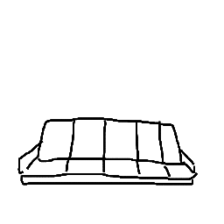


	Positive Image
	Class: couch


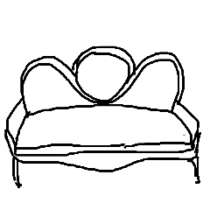


					Predicted Images
					   Grad CAM



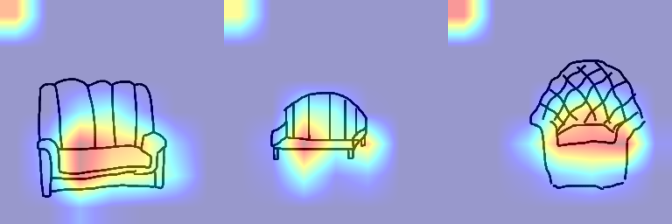

	cos_sim:0.976 			cos_sim:0.902 			cos_sim:0.846
	pred_class: couch 		pred_class: bench 		pred_class: chair


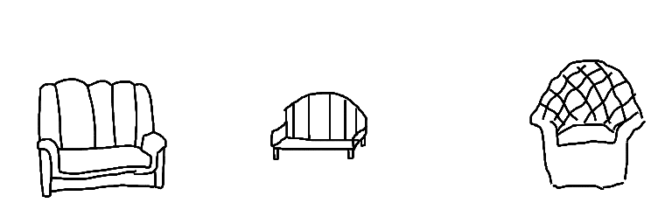


	Input Image
	Class: armor


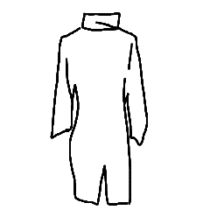


	Positive Image
	Class: armor


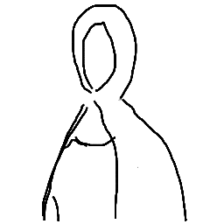


					Predicted Images
					   Grad CAM



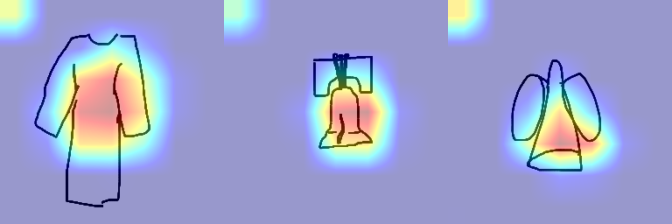

	cos_sim:0.983 			cos_sim:0.682 			cos_sim:0.666
	pred_class: armor 		pred_class: bell 		pred_class: cannon


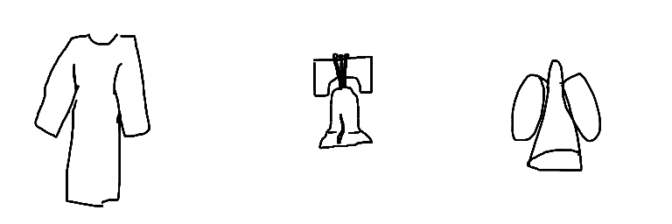


	Input Image
	Class: seal


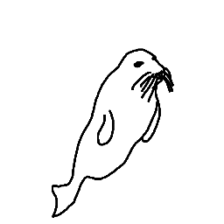


	Positive Image
	Class: seal


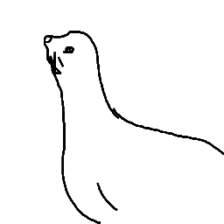


					Predicted Images
					   Grad CAM



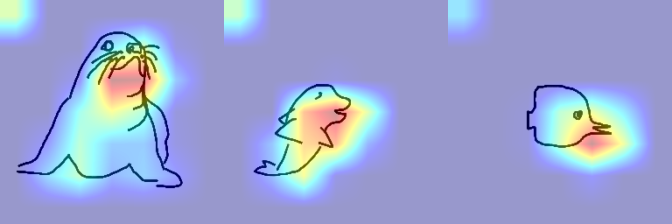

	cos_sim:0.979 			cos_sim:0.886 			cos_sim:0.873
	pred_class: seal 		pred_class: dolphin 		pred_class: fish


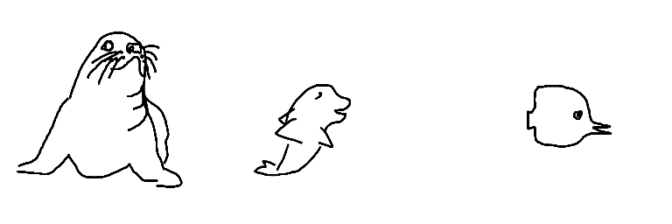


	Input Image
	Class: swan


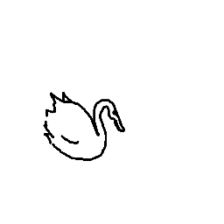


	Positive Image
	Class: swan


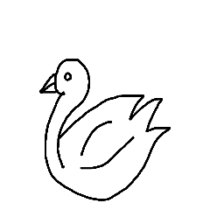


					Predicted Images
					   Grad CAM



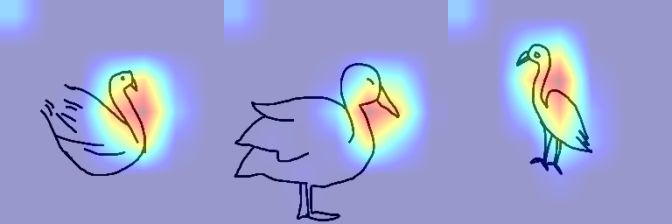

	cos_sim:0.987 			cos_sim:0.942 			cos_sim:0.935
	pred_class: swan 		pred_class: duck 		pred_class: wading_bird


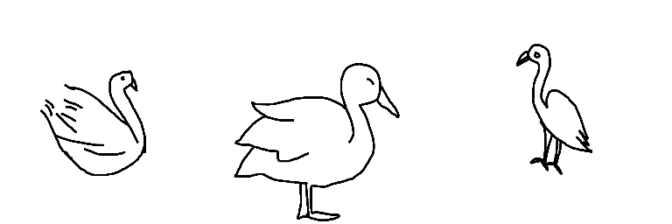


	Input Image
	Class: umbrella


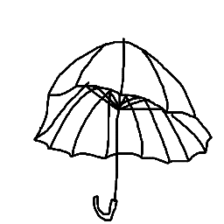


	Positive Image
	Class: umbrella


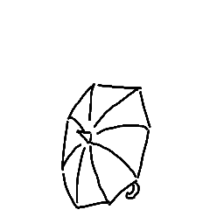


					Predicted Images
					   Grad CAM



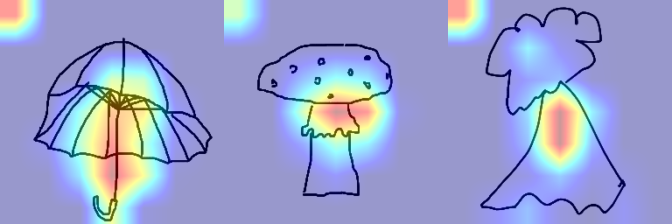

	cos_sim:1.000 			cos_sim:0.850 			cos_sim:0.799
	pred_class: umbrella 		pred_class: mushroom 		pred_class: volcano


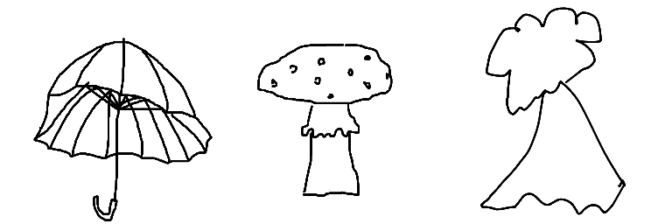


	Input Image
	Class: seal


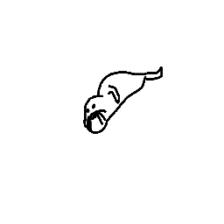


	Positive Image
	Class: seal


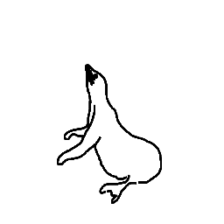


					Predicted Images
					   Grad CAM



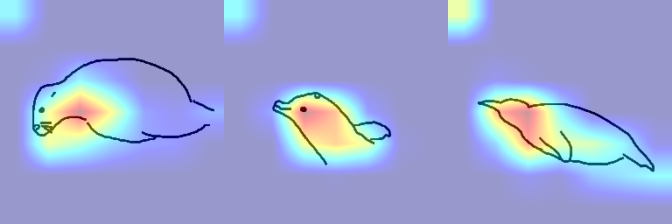

	cos_sim:0.964 			cos_sim:0.894 			cos_sim:0.868
	pred_class: seal 		pred_class: dolphin 		pred_class: penguin


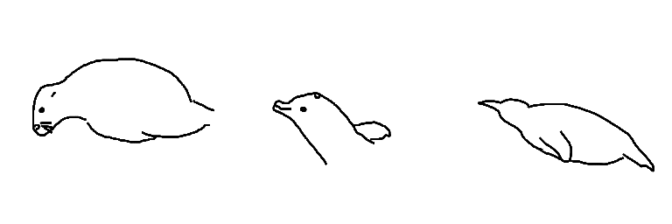


	Input Image
	Class: dolphin


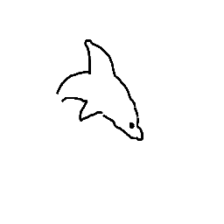


	Positive Image
	Class: dolphin


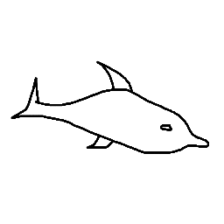


					Predicted Images
					   Grad CAM



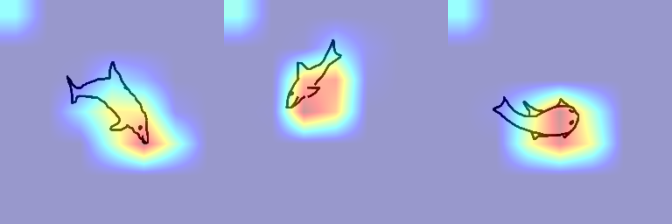

	cos_sim:0.984 			cos_sim:0.945 			cos_sim:0.901
	pred_class: dolphin 		pred_class: shark 		pred_class: fish


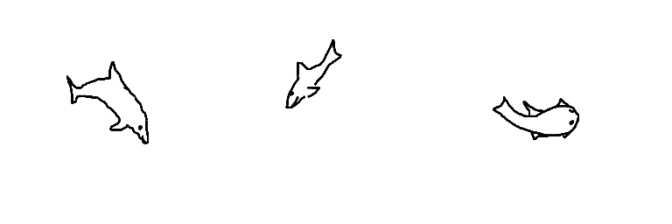


	Input Image
	Class: skyscraper


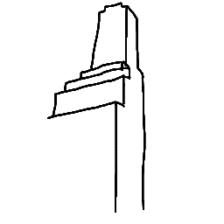


	Positive Image
	Class: skyscraper


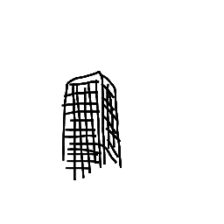


					Predicted Images
					   Grad CAM



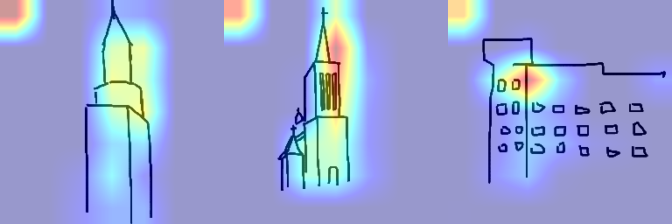

	cos_sim:0.981 			cos_sim:0.954 			cos_sim:0.941
	pred_class: skyscraper 		pred_class: church 		pred_class: castle


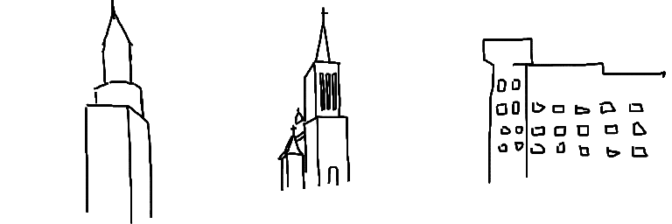


	Input Image
	Class: kangaroo


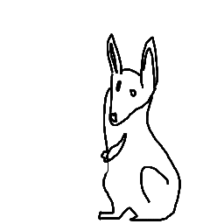


	Positive Image
	Class: kangaroo


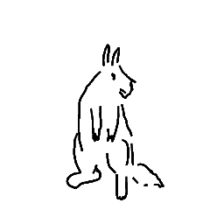


					Predicted Images
					   Grad CAM



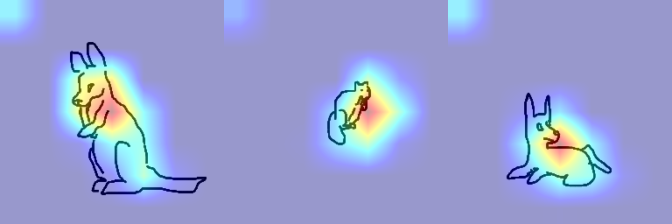

	cos_sim:0.974 			cos_sim:0.936 			cos_sim:0.934
	pred_class: kangaroo 		pred_class: squirrel 		pred_class: dog


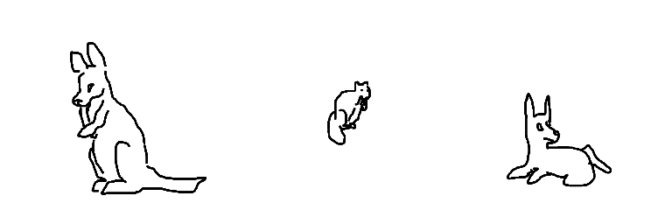


	Input Image
	Class: ape


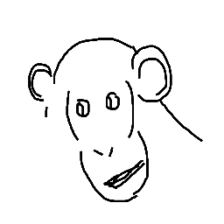


	Positive Image
	Class: ape


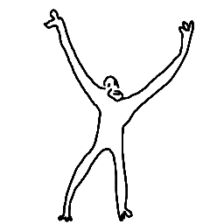


					Predicted Images
					   Grad CAM



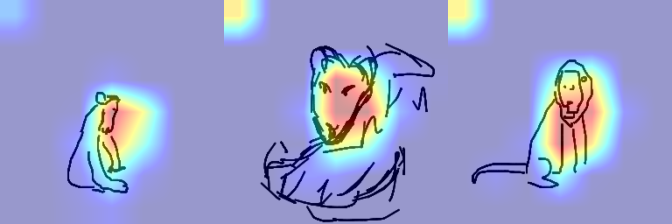

	cos_sim:0.942 			cos_sim:0.880 			cos_sim:0.865
	pred_class: ape 		pred_class: bear 		pred_class: lion


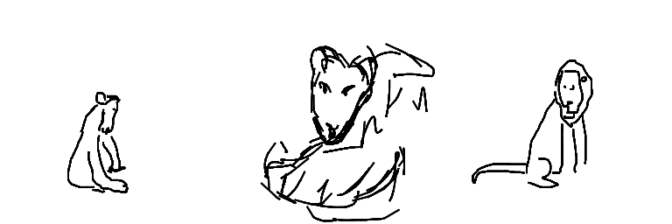


	Input Image
	Class: sea_turtle


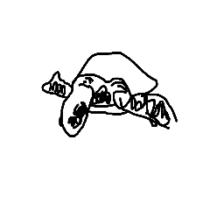


	Positive Image
	Class: sea_turtle


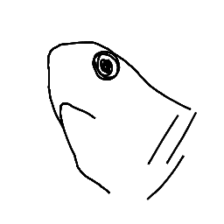


					Predicted Images
					   Grad CAM



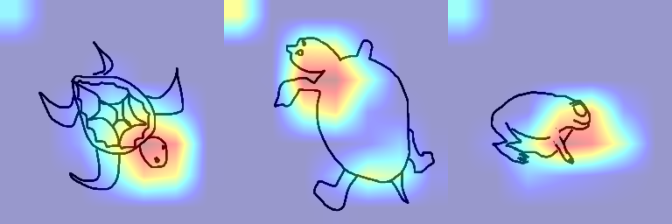

	cos_sim:0.937 			cos_sim:0.881 			cos_sim:0.843
	pred_class: sea_turtle 		pred_class: turtle 		pred_class: frog


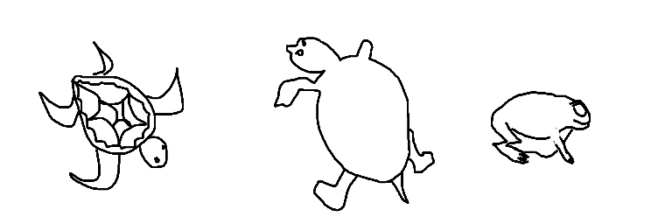


	Input Image
	Class: window


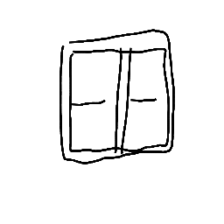


	Positive Image
	Class: window


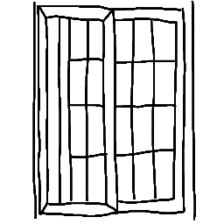


					Predicted Images
					   Grad CAM



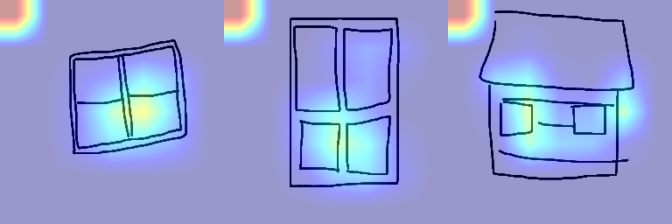

	cos_sim:0.990 			cos_sim:0.954 			cos_sim:0.896
	pred_class: window 		pred_class: door 		pred_class: cabin


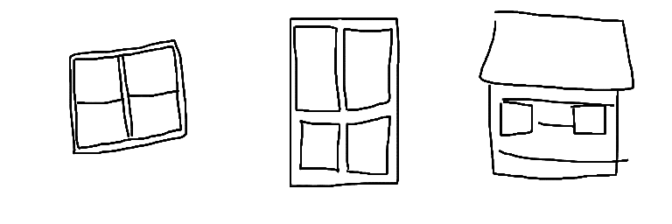


	Input Image
	Class: tiger


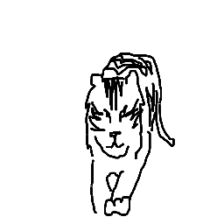


	Positive Image
	Class: tiger


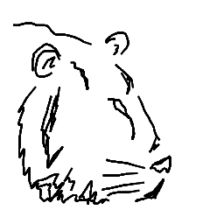


					Predicted Images
					   Grad CAM



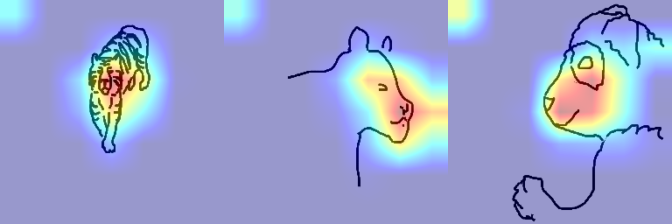

	cos_sim:0.977 			cos_sim:0.948 			cos_sim:0.935
	pred_class: tiger 		pred_class: lion 		pred_class: bear


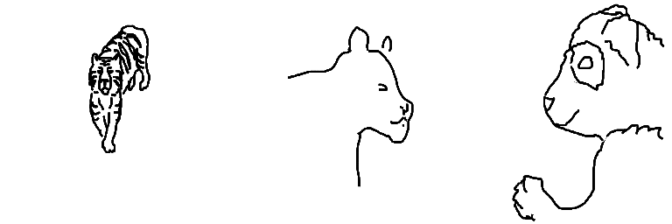


	Input Image
	Class: snail


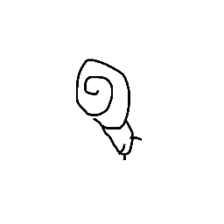


	Positive Image
	Class: snail


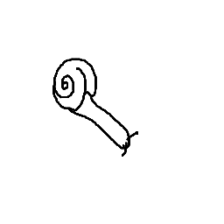


					Predicted Images
					   Grad CAM



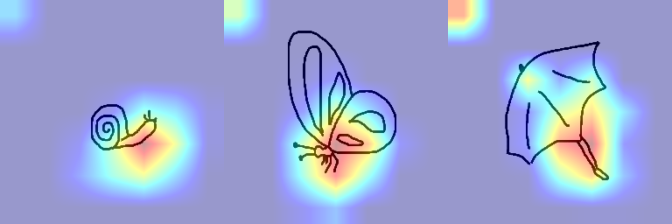

	cos_sim:0.989 			cos_sim:0.736 			cos_sim:0.626
	pred_class: snail 		pred_class: butterfly 		pred_class: umbrella


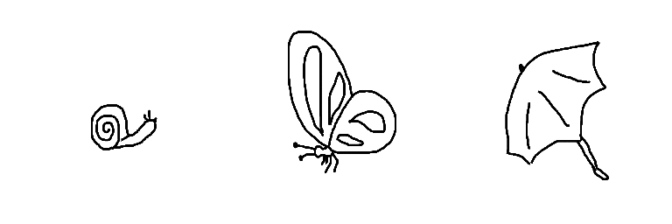


	Input Image
	Class: pineapple


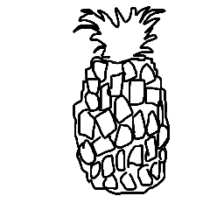


	Positive Image
	Class: pineapple


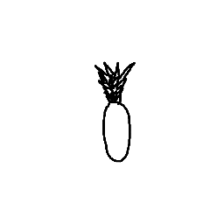


					Predicted Images
					   Grad CAM



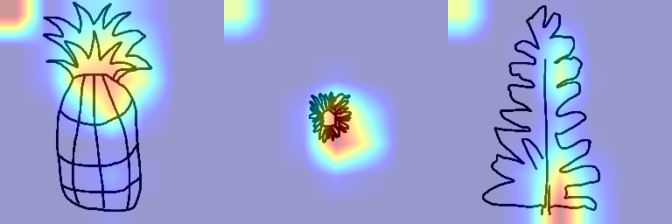

	cos_sim:0.987 			cos_sim:0.796 			cos_sim:0.782
	pred_class: pineapple 		pred_class: flower 		pred_class: tree


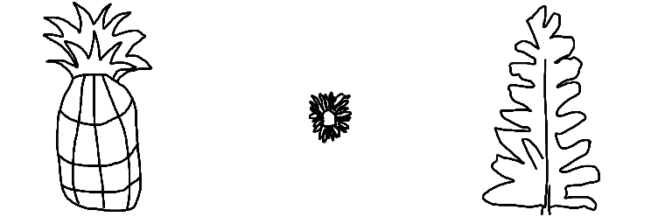


	Input Image
	Class: hermit_crab


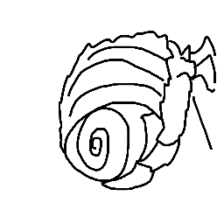


	Positive Image
	Class: hermit_crab


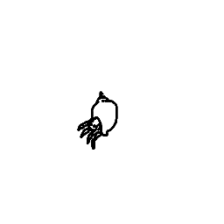


					Predicted Images
					   Grad CAM



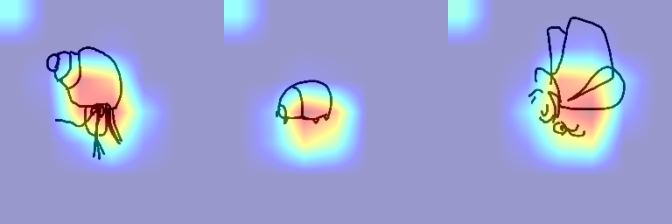

	cos_sim:0.934 			cos_sim:0.855 			cos_sim:0.828
	pred_class: hermit_crab 		pred_class: beetle 		pred_class: butterfly


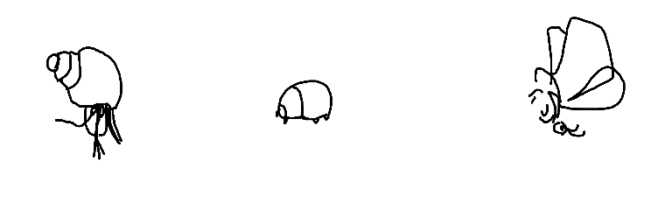


	Input Image
	Class: bicycle


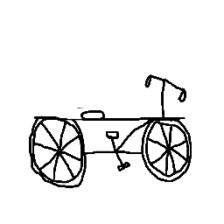


	Positive Image
	Class: bicycle


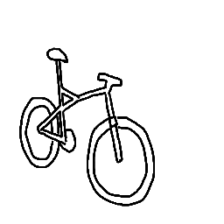


					Predicted Images
					   Grad CAM



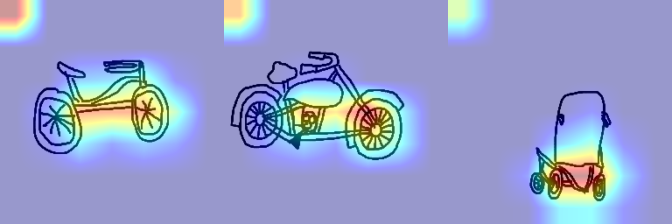

	cos_sim:0.985 			cos_sim:0.963 			cos_sim:0.926
	pred_class: bicycle 		pred_class: motorcycle 		pred_class: wheelchair


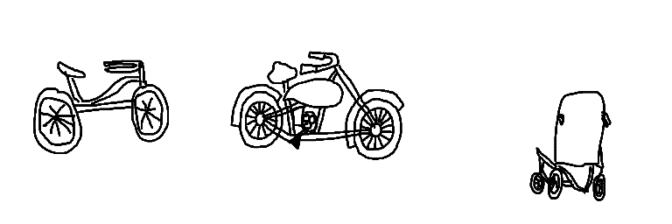


	Input Image
	Class: blimp


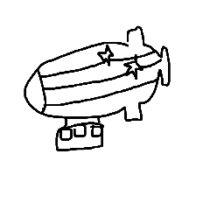


	Positive Image
	Class: blimp


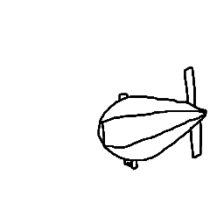


					Predicted Images
					   Grad CAM



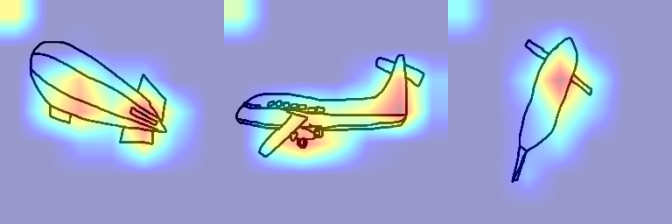

	cos_sim:0.954 			cos_sim:0.749 			cos_sim:0.742
	pred_class: blimp 		pred_class: airplane 		pred_class: helicopter


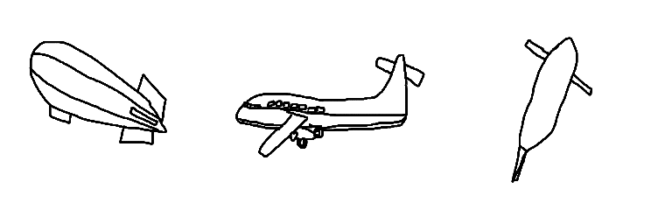


	Input Image
	Class: camel


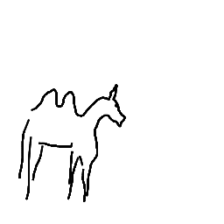


	Positive Image
	Class: camel


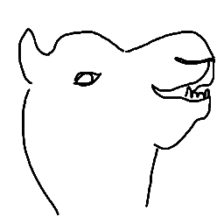


					Predicted Images
					   Grad CAM



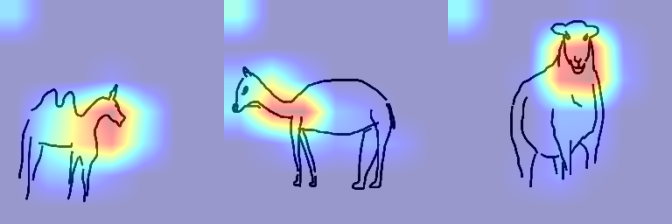

	cos_sim:1.000 			cos_sim:0.933 			cos_sim:0.926
	pred_class: camel 		pred_class: deer 		pred_class: sheep


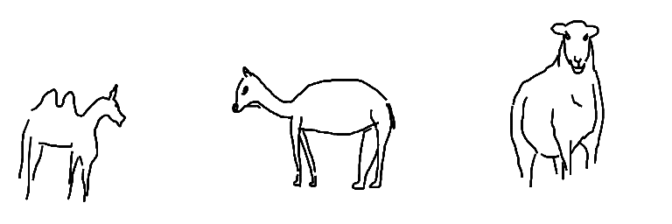


	Input Image
	Class: hat


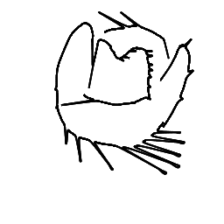


	Positive Image
	Class: hat


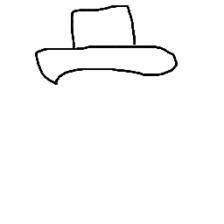


					Predicted Images
					   Grad CAM



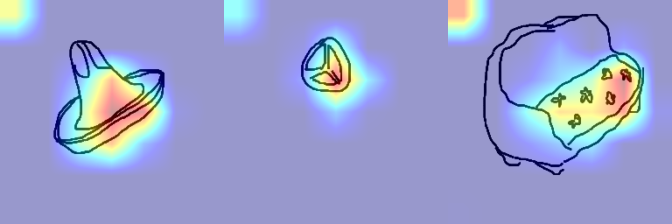

	cos_sim:0.816 			cos_sim:0.746 			cos_sim:0.743
	pred_class: hat 		pred_class: pretzel 		pred_class: couch


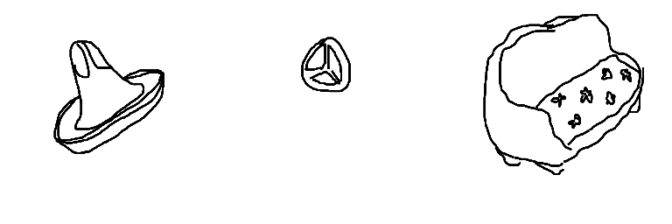


	Input Image
	Class: butterfly


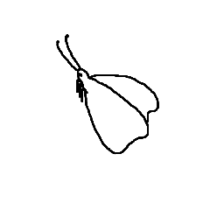


	Positive Image
	Class: butterfly


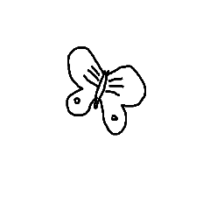


					Predicted Images
					   Grad CAM



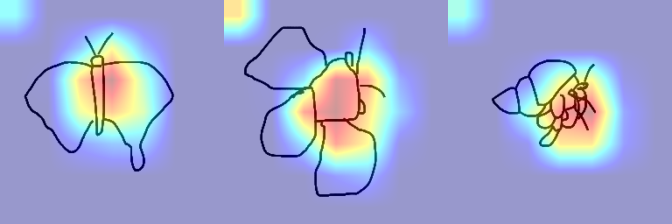

	cos_sim:0.982 			cos_sim:0.859 			cos_sim:0.813
	pred_class: butterfly 		pred_class: bee 		pred_class: hermit_crab


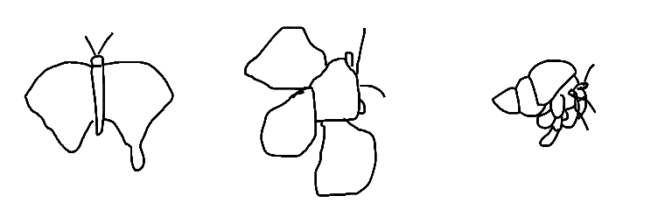


	Input Image
	Class: chicken


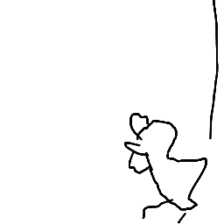


	Positive Image
	Class: chicken


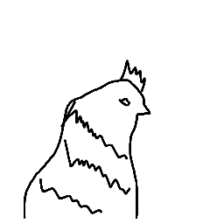


					Predicted Images
					   Grad CAM



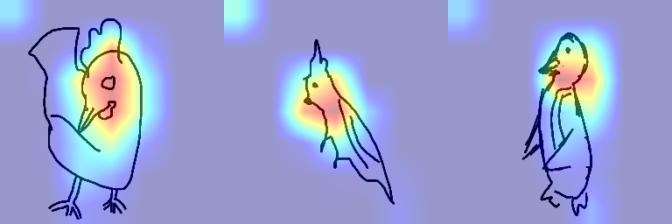

	cos_sim:0.913 			cos_sim:0.851 			cos_sim:0.845
	pred_class: chicken 		pred_class: parrot 		pred_class: penguin


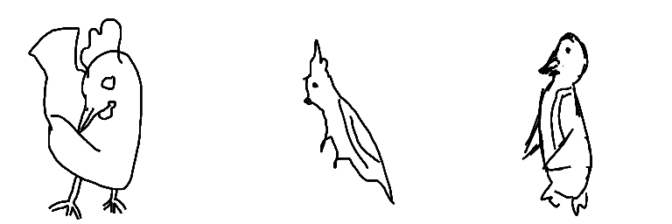


	Input Image
	Class: raccoon


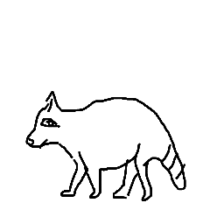


	Positive Image
	Class: raccoon


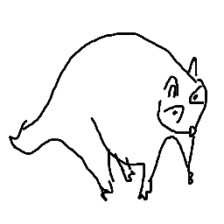


					Predicted Images
					   Grad CAM



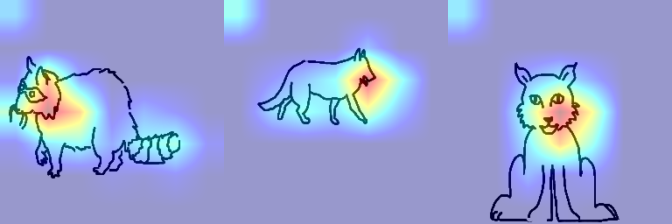

	cos_sim:0.978 			cos_sim:0.942 			cos_sim:0.939
	pred_class: raccoon 		pred_class: dog 		pred_class: cat


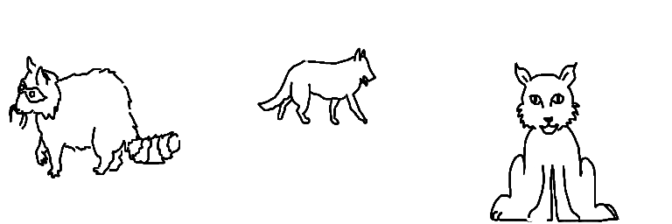


	Input Image
	Class: raccoon


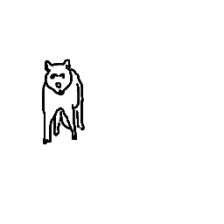


	Positive Image
	Class: raccoon


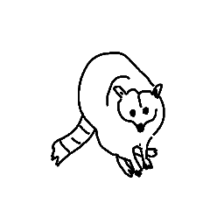


					Predicted Images
					   Grad CAM



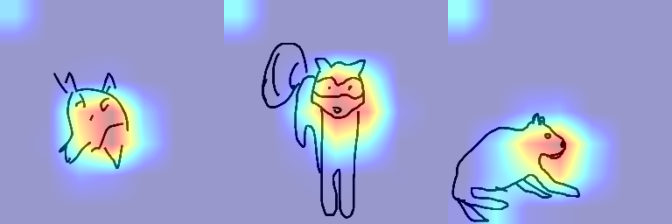

	cos_sim:0.966 			cos_sim:0.963 			cos_sim:0.960
	pred_class: bear 		pred_class: raccoon 		pred_class: tiger


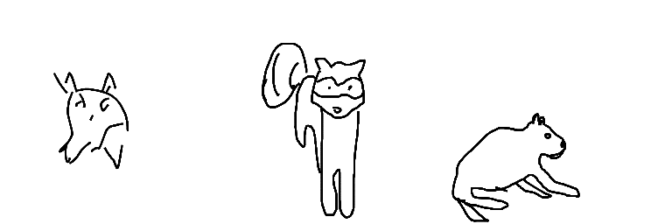


	Input Image
	Class: cup


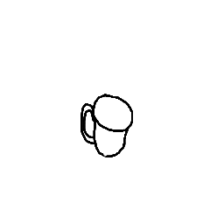


	Positive Image
	Class: cup


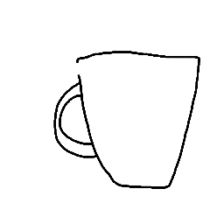


					Predicted Images
					   Grad CAM



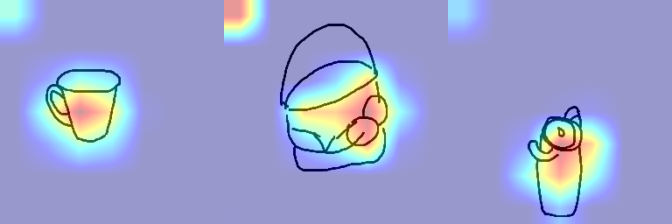

	cos_sim:0.987 			cos_sim:0.864 			cos_sim:0.806
	pred_class: cup 		pred_class: hamburger 		pred_class: teapot


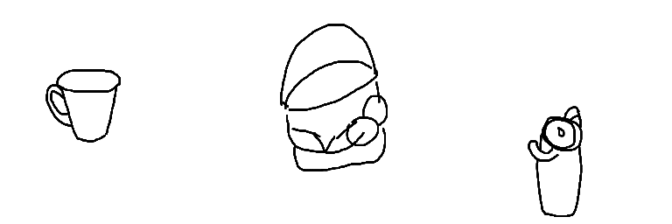


	Input Image
	Class: teddy_bear


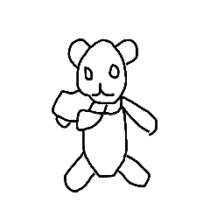


	Positive Image
	Class: teddy_bear


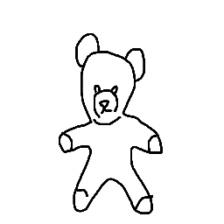


					Predicted Images
					   Grad CAM



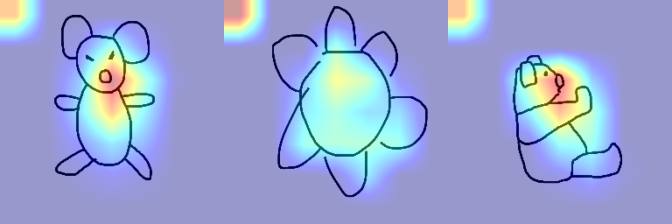

	cos_sim:0.986 			cos_sim:0.773 			cos_sim:0.743
	pred_class: teddy_bear 		pred_class: flower 		pred_class: bear


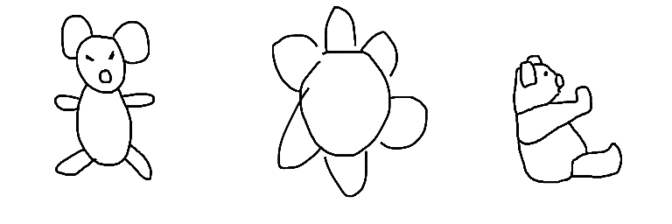


	Input Image
	Class: ray


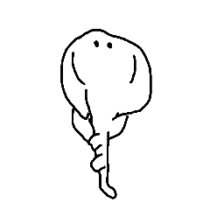


	Positive Image
	Class: ray


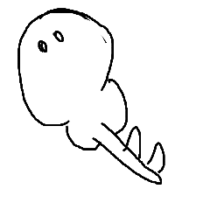


					Predicted Images
					   Grad CAM



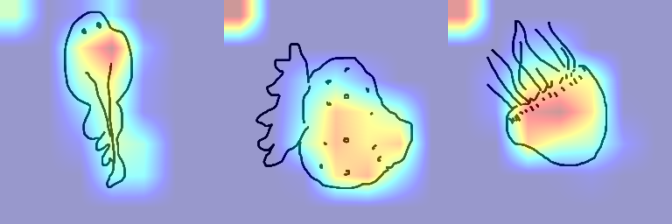

	cos_sim:0.943 			cos_sim:0.863 			cos_sim:0.836
	pred_class: ray 		pred_class: strawberry 		pred_class: jellyfish


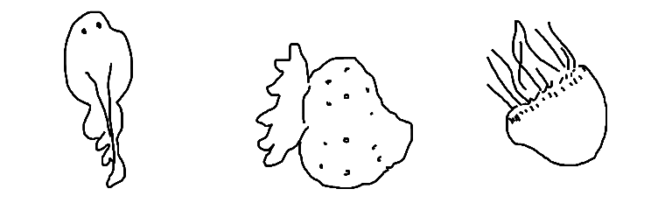


	Input Image
	Class: penguin


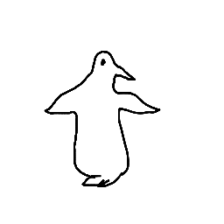


	Positive Image
	Class: penguin


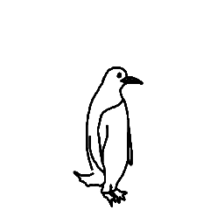


					Predicted Images
					   Grad CAM



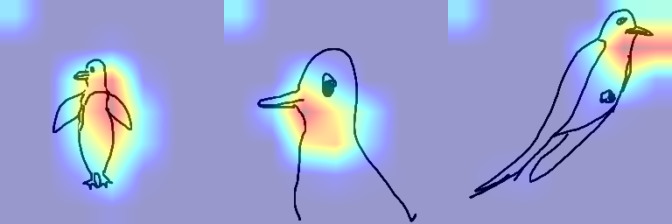

	cos_sim:0.973 			cos_sim:0.948 			cos_sim:0.930
	pred_class: penguin 		pred_class: seagull 		pred_class: songbird


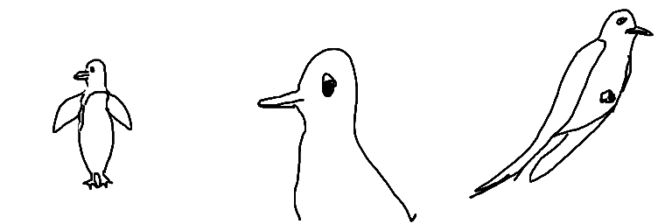


	Input Image
	Class: pickup_truck


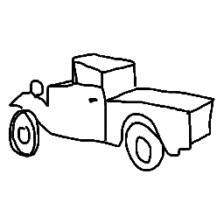


	Positive Image
	Class: pickup_truck


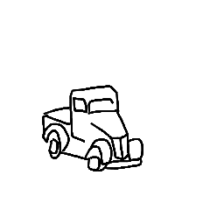


					Predicted Images
					   Grad CAM



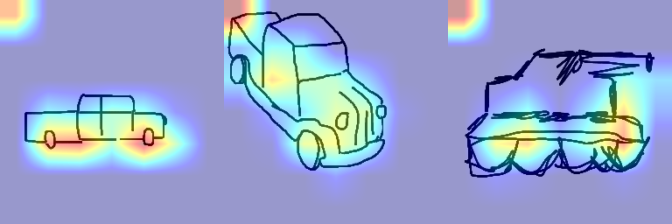

	cos_sim:0.986 			cos_sim:0.933 			cos_sim:0.887
	pred_class: pickup_truck 		pred_class: car_(sedan) 		pred_class: tank


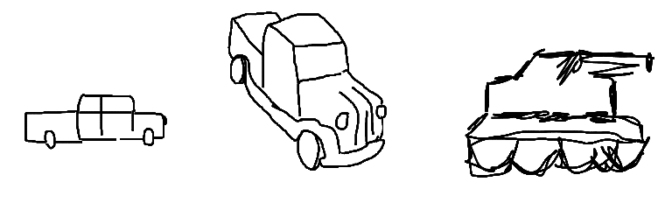


	Input Image
	Class: sheep


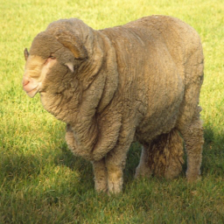


	Positive Image
	Class: sheep


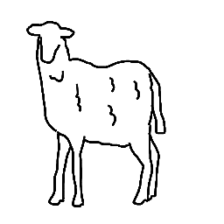


					Predicted Images
					   Grad CAM



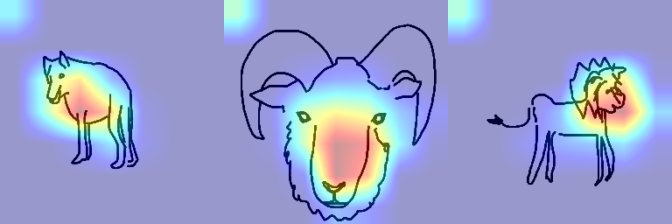

	cos_sim:0.944 			cos_sim:0.939 			cos_sim:0.933
	pred_class: dog 		pred_class: sheep 		pred_class: lion


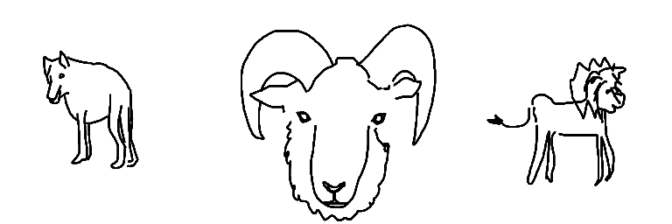


	Input Image
	Class: bicycle


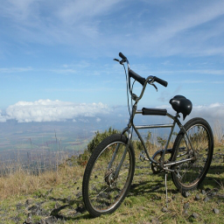


	Positive Image
	Class: bicycle


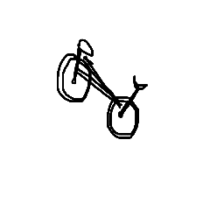


					Predicted Images
					   Grad CAM



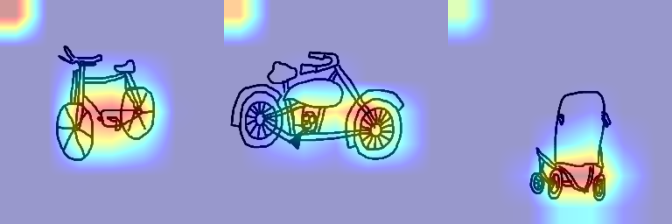

	cos_sim:0.976 			cos_sim:0.937 			cos_sim:0.896
	pred_class: bicycle 		pred_class: motorcycle 		pred_class: wheelchair


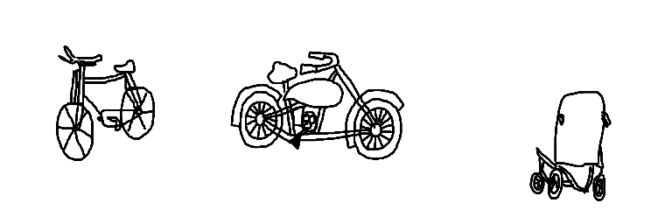


	Input Image
	Class: chair


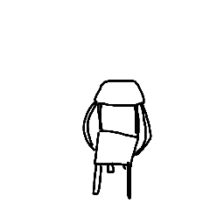


	Positive Image
	Class: chair


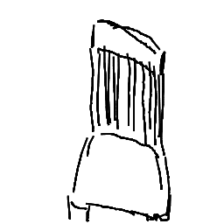


					Predicted Images
					   Grad CAM



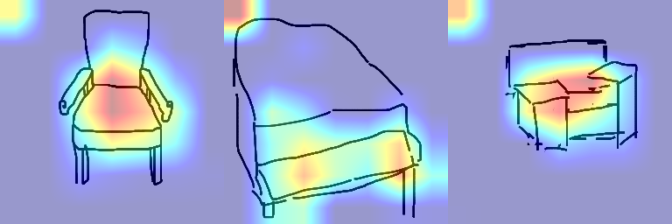

	cos_sim:0.985 			cos_sim:0.893 			cos_sim:0.889
	pred_class: chair 		pred_class: piano 		pred_class: bench


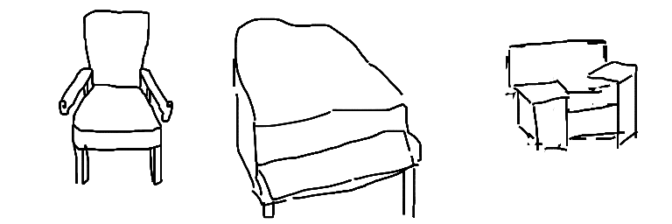


	Input Image
	Class: pistol


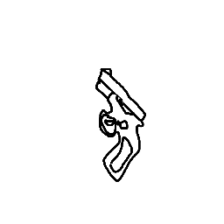


	Positive Image
	Class: pistol


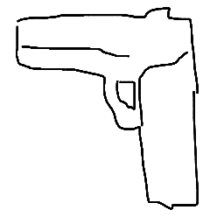


					Predicted Images
					   Grad CAM



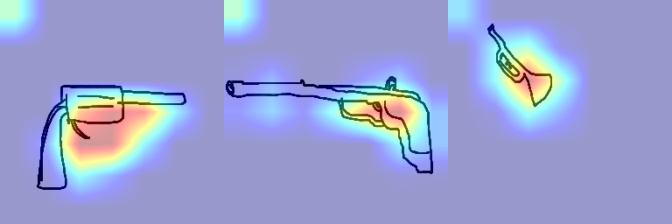

	cos_sim:0.961 			cos_sim:0.893 			cos_sim:0.756
	pred_class: pistol 		pred_class: rifle 		pred_class: trumpet


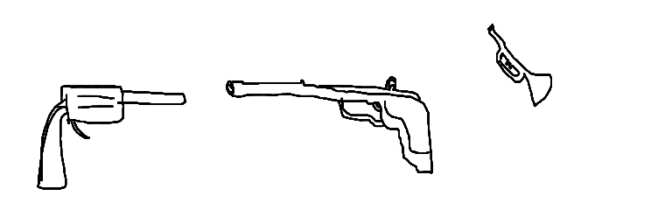


	Input Image
	Class: scorpion


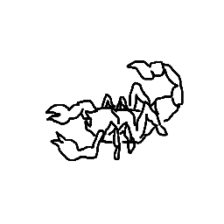


	Positive Image
	Class: scorpion


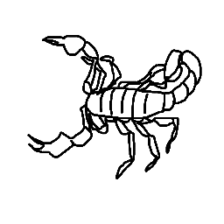


					Predicted Images
					   Grad CAM



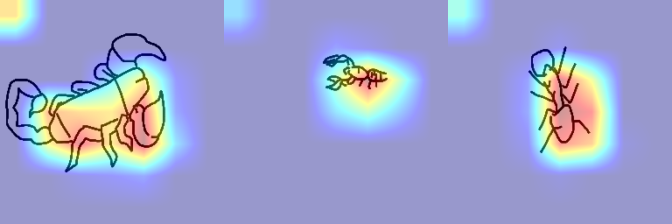

	cos_sim:0.986 			cos_sim:0.961 			cos_sim:0.923
	pred_class: scorpion 		pred_class: lobster 		pred_class: ant


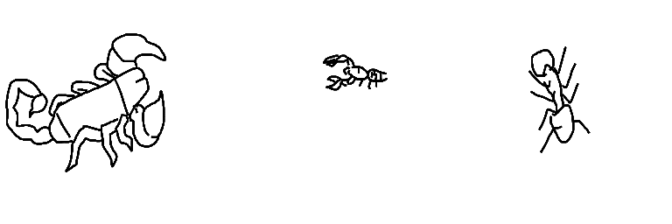


	Input Image
	Class: horse


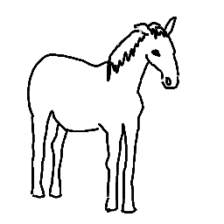


	Positive Image
	Class: horse


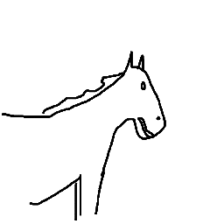


					Predicted Images
					   Grad CAM



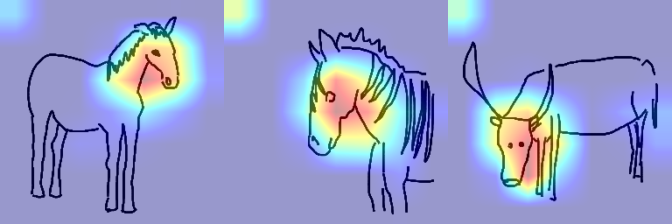

	cos_sim:1.000 			cos_sim:0.965 			cos_sim:0.944
	pred_class: horse 		pred_class: zebra 		pred_class: cow


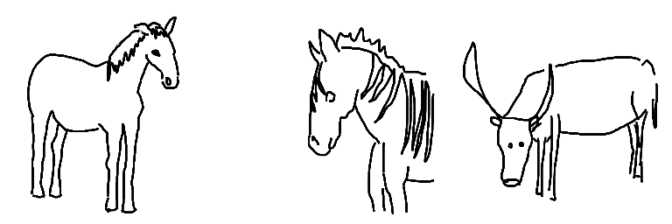


	Input Image
	Class: hamburger


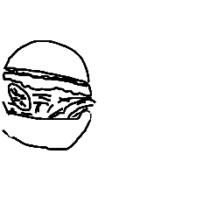


	Positive Image
	Class: hamburger


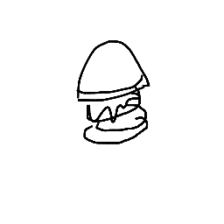


					Predicted Images
					   Grad CAM



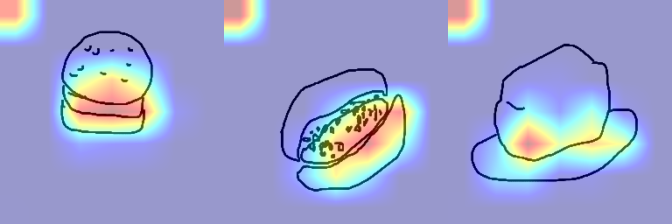

	cos_sim:0.921 			cos_sim:0.837 			cos_sim:0.836
	pred_class: hamburger 		pred_class: hotdog 		pred_class: bread


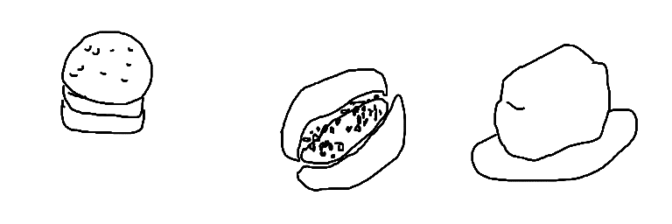


	Input Image
	Class: sailboat


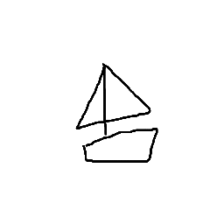


	Positive Image
	Class: sailboat


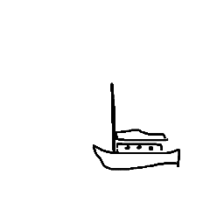


					Predicted Images
					   Grad CAM



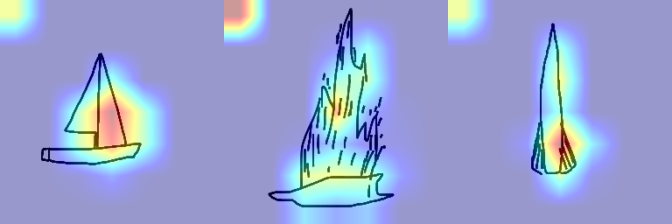

	cos_sim:0.977 			cos_sim:0.764 			cos_sim:0.746
	pred_class: sailboat 		pred_class: geyser 		pred_class: rocket


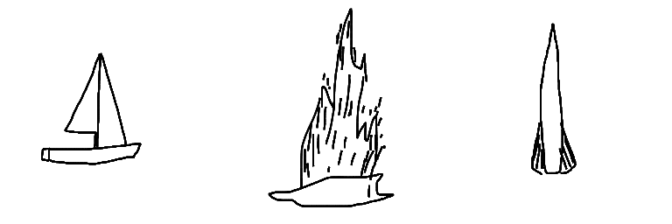


	Input Image
	Class: crab


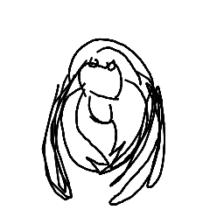


	Positive Image
	Class: crab


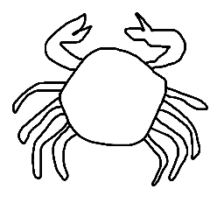


					Predicted Images
					   Grad CAM



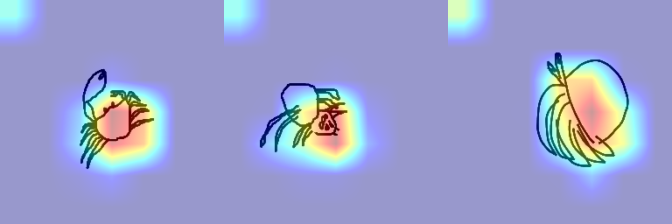

	cos_sim:0.967 			cos_sim:0.955 			cos_sim:0.934
	pred_class: crab 		pred_class: spider 		pred_class: hermit_crab


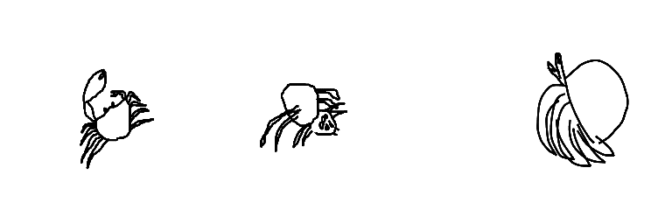


	Input Image
	Class: squirrel


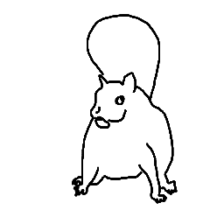


	Positive Image
	Class: squirrel


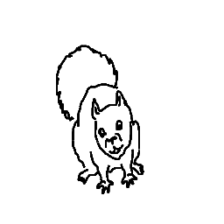


					Predicted Images
					   Grad CAM



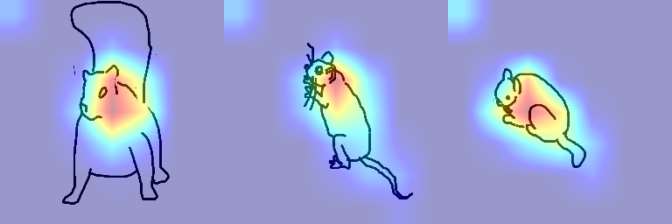

	cos_sim:0.983 			cos_sim:0.953 			cos_sim:0.946
	pred_class: squirrel 		pred_class: mouse 		pred_class: cat


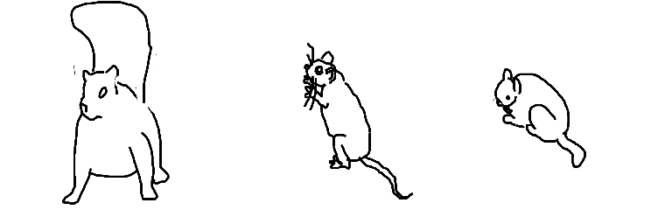

In [4]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fms_ims_all = results['fms_ims_all']
fms_poss_all = results['fms_poss_all']
fms_negs_all = results['fms_negs_all']
ims = results['ims']
all_classes = results['classes_all']
poss = results['poss']
negs = results['negs']
indices_all = results["topk_inds"]
values_all = results["top_vals"]
classes_all = results["top_r_list"]

cnt = 0
    
for i, im in enumerate(ims):
    if i == 40:
        break
    print('\n\tInput Image')
    print(f"\tClass: {idx_to_clss[all_classes[i].item()]}")
    display(Image.fromarray((ims[i]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)))
    print('\n\tPositive Image')
    print(f"\tClass: {idx_to_clss[all_classes[i].item()]}")
    display(Image.fromarray((poss[i]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)))
    cnt += 1

    img_list = []
    img_list_gt = []
    pil_visualization = []
    for j in indices_all[i][:15]:
        img = (poss[j]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)
        img_list.append(img)
        oris = poss[j]
        ori_cam = ((oris)*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8) / 255
        cam = GradCAM(model=m, target_layers=[m.features[-1]], use_cuda=True)
        grayscale_cam = cam(input_tensor=oris.unsqueeze(0))
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(ori_cam, grayscale_cam, image_weight=0.6, use_rgb = True)
        pil_visualization.append(visualization)
    print('\n\t\t\t\t\tPredicted Images')
    print('\t\t\t\t\t   Grad CAM\n')
    display(Image.fromarray(cv2.hconcat(pil_visualization)))
        
    if len(values_all[i]) < 3:
        pass
    else:
        print(f'\tcos_sim:{values_all[i][0]:.3f} \t\t\tcos_sim:{values_all[i][1]:.3f} \t\t\tcos_sim:{values_all[i][2]:.3f}')
        print(f'\tpred_class: {idx_to_clss[classes_all[i][0]]} \t\tpred_class: {idx_to_clss[classes_all[i][1]]} \t\tpred_class: {idx_to_clss[classes_all[i][2]]}')
    display(Image.fromarray(np.concatenate(img_list, axis=1)))

# GradCAM


Triplet: 	Real Image 		 Positive Sketch 		 Negative Sketch



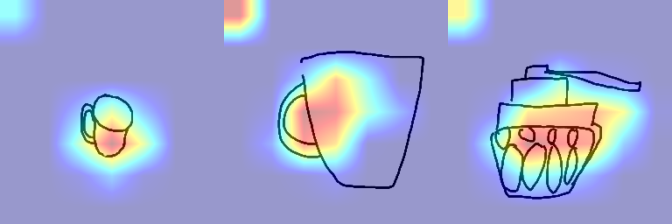


Triplet: 	Real Image 		 Positive Sketch 		 Negative Sketch



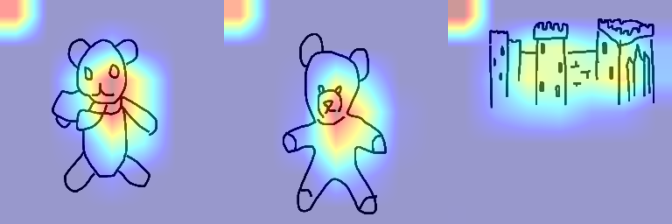


Triplet: 	Real Image 		 Positive Sketch 		 Negative Sketch



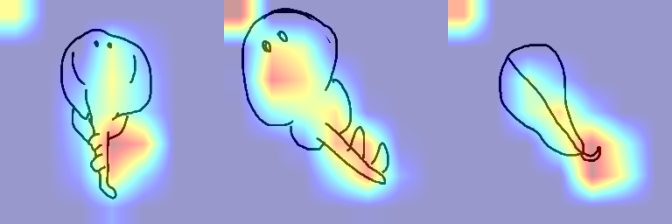


Triplet: 	Real Image 		 Positive Sketch 		 Negative Sketch



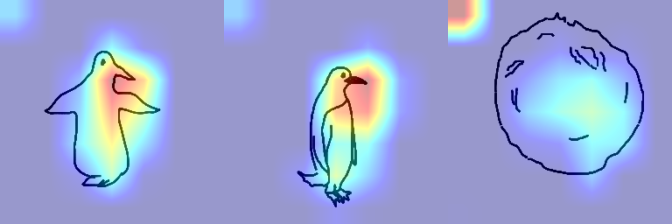


Triplet: 	Real Image 		 Positive Sketch 		 Negative Sketch



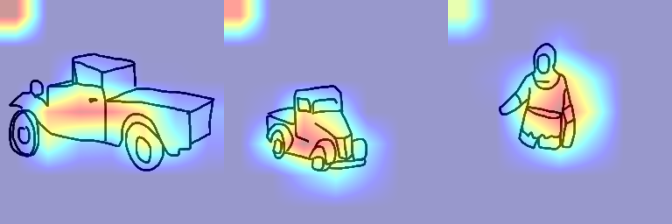

In [5]:
top3, top1, cnt = 0, 0, 0

offset = 25
list_len = 5

for i in range(offset, offset+list_len):

    oris = ims[i]
    pos_imgs = poss[i]
    neg_imgs = negs[i]

    ori_cam = ((oris)*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8) / 255
    pos_cam = ((pos_imgs)*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8) / 255
    neg_cam = ((neg_imgs)*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8) / 255

    cam = GradCAM(model=m, target_layers=[m.features[-1]], use_cuda=True)
    grayscale_cam = cam(input_tensor=oris.unsqueeze(0))
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(ori_cam, grayscale_cam, image_weight=0.6, use_rgb = True)
    
    grayscale_cam_pos = cam(input_tensor=pos_imgs.unsqueeze(0))
    grayscale_cam_pos = grayscale_cam_pos[0, :]
    visualization_pos = show_cam_on_image(pos_cam, grayscale_cam_pos, image_weight=0.6, use_rgb = True)
    
    grayscale_cam_neg = cam(input_tensor=neg_imgs.unsqueeze(0))
    grayscale_cam_neg = grayscale_cam_neg[0, :]
    visualization_neg = show_cam_on_image(neg_cam, grayscale_cam_neg, image_weight=0.6, use_rgb = True)
    
    pil_visualization = Image.fromarray(cv2.hconcat([visualization, visualization_pos, visualization_neg]))        
    
    print("\nTriplet: \tReal Image \t\t Positive Sketch \t\t Negative Sketch\n")
    display(pil_visualization)